In [ ]:
# First, we need to mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

# Unzip the dataset folder from Google Drive
import zipfile
import os

# Set the path to the zip file and extract location
zip_file_path = '/content/drive/MyDrive/Colab Notebooks/public_dataset.zip'
extract_path = '/content/drive/MyDrive/Colab Notebooks/public_dataset/'

# Unzip the dataset
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

# Now, let's run the rest of the code with the updated dataset path

# Import necessary libraries for models and metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import glob
import librosa

# Define models for comparison
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Gaussian Naive Bayes": GaussianNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(eval_metric='mlogloss')
}

# Load dataset from the directory
npz_files = glob.glob(f"{extract_path}/**/*.npz", recursive=True)

# Function to load and process the dataset and features
def load_and_process_data(npz_files):
    audio_features_list = []
    imu_features_list = []
    labels_list = []

    def extract_audio_features(audio_segment, sr=16000):
        """Extracts MFCC, spectral, and time-domain features from audio."""
        mfccs = np.mean(librosa.feature.mfcc(y=audio_segment, sr=sr, n_mfcc=13), axis=1)
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio_segment, sr=sr))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio_segment, sr=sr))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio_segment, sr=sr))
        zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=audio_segment))
        rms_energy = np.mean(librosa.feature.rms(y=audio_segment))

        return np.concatenate([mfccs, [spectral_centroid, spectral_bandwidth, spectral_rolloff, zero_crossing_rate, rms_energy]])

    def extract_imu_features(imu_segment):
        """Extracts statistical features from IMU signals."""
        features = []
        for i in range(imu_segment.shape[1]):  # Loop over accelerometer & gyroscope axes
            axis_data = imu_segment[:, i]
            features.append(np.mean(axis_data))    # Mean
            features.append(np.std(axis_data))     # Standard deviation
            features.append(np.min(axis_data))     # Min
            features.append(np.max(axis_data))     # Max
            features.append(np.median(axis_data))  # Median
        return np.array(features)

    # Iterate through all files and extract features
    for npz_file in npz_files:
        data = np.load(npz_file)

        # Extract raw data
        audio_data = data["audio_data"]  # Shape: (N, M, 2)
        imu_data = data["imu_data"]      # Shape: (N, L, 6)
        labels = data["labels"]          # Shape: (N,)

        for i in range(audio_data.shape[0]):
            # Process each audio segment (take outer microphone)
            audio_features = extract_audio_features(audio_data[i, :, 0])
            imu_features = extract_imu_features(imu_data[i, :, :])

            audio_features_list.append(audio_features)
            imu_features_list.append(imu_features)
            labels_list.append(labels[i])

    # Convert to NumPy arrays
    audio_features_array = np.array(audio_features_list)
    imu_features_array = np.array(imu_features_list)
    labels_array = np.array(labels_list)

    print(f"Extracted {audio_features_array.shape[0]} samples")
    return audio_features_array, imu_features_array, labels_array

# Load and process data
audio_features_array, imu_features_array, labels_array = load_and_process_data(npz_files)

Mounted at /content/drive
Dataset extracted to: /content/drive/MyDrive/Colab Notebooks/public_dataset/
Extracted 31960 samples



🔹 Training Logistic Regression...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


🔹 Logistic Regression Validation Accuracy: 0.8220
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89      2398
         1.0       0.71      0.49      0.58       798

    accuracy                           0.82      3196
   macro avg       0.78      0.71      0.73      3196
weighted avg       0.81      0.82      0.81      3196

Confusion Matrix:
[[2239  159]
 [ 410  388]]
✅ Logistic Regression Test Accuracy: 0.8248
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89      4816
         1.0       0.71      0.49      0.58      1576

    accuracy                           0.82      6392
   macro avg       0.78      0.71      0.73      6392
weighted avg       0.81      0.82      0.81      6392

Confusion Matrix:
[[4499  317]
 [ 803  773]]

🔹 Training Gaussian Naive Bayes...
🔹 Gaussian Naive Bayes Validation Accuracy: 0.7319
Classification Report:
      

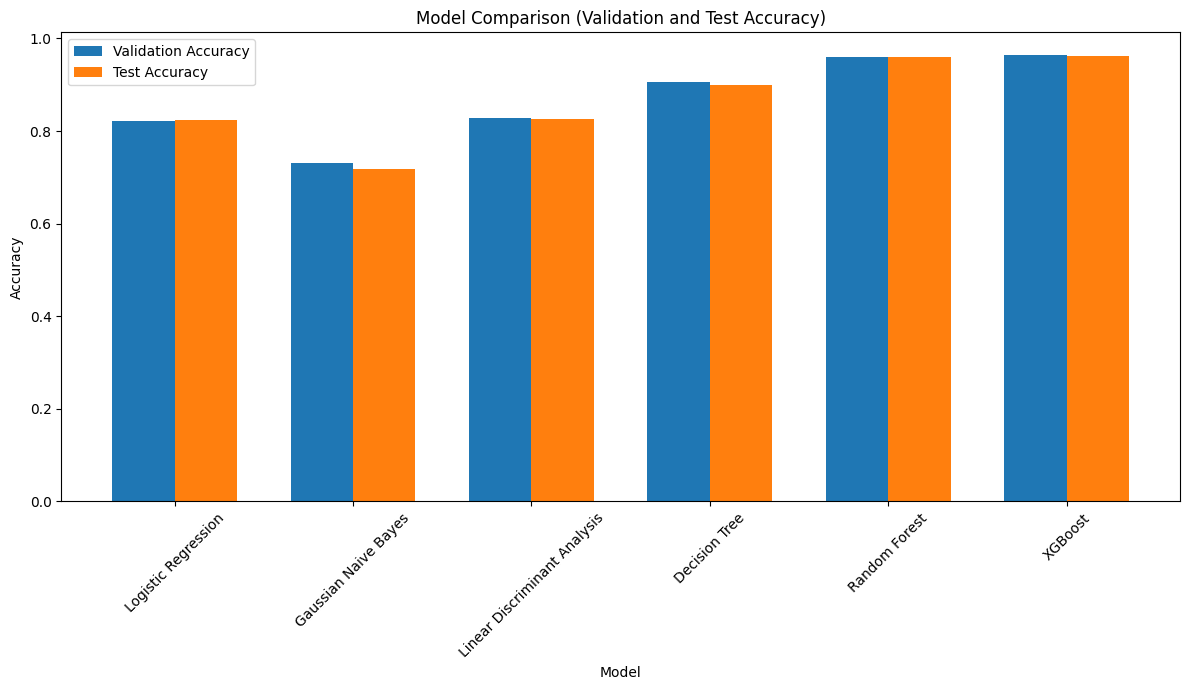

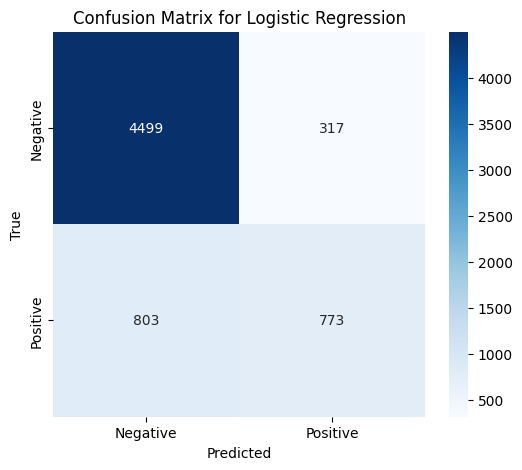

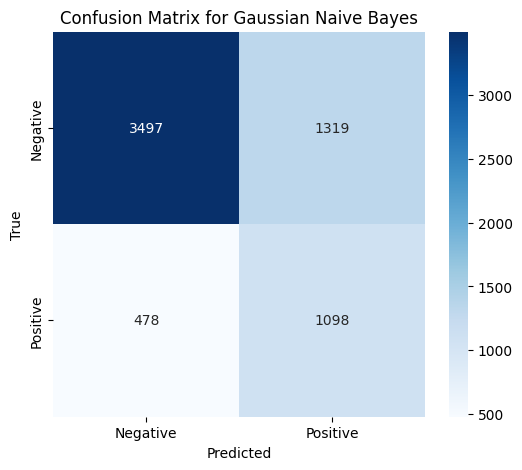

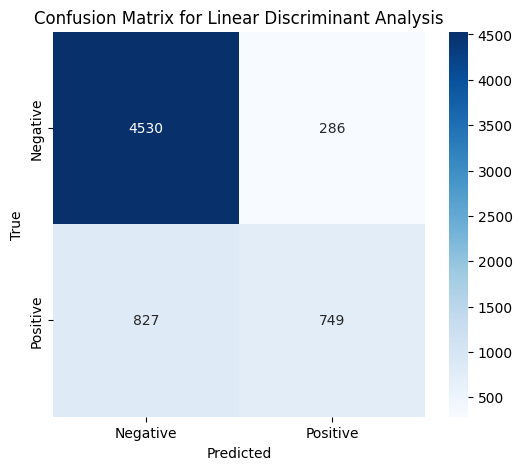

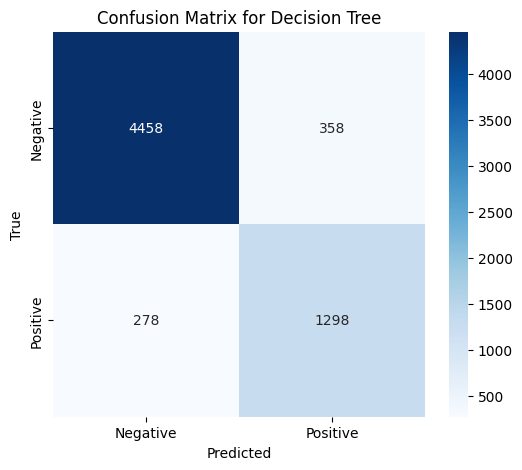

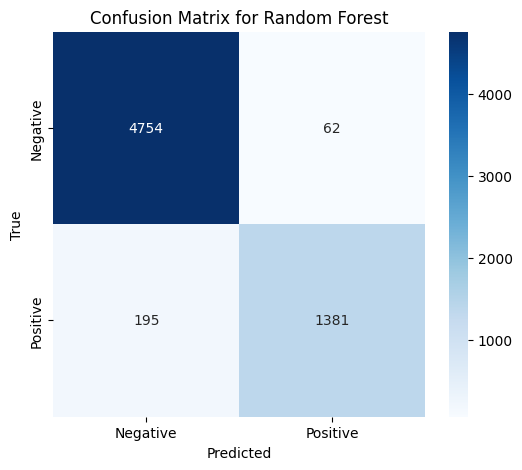

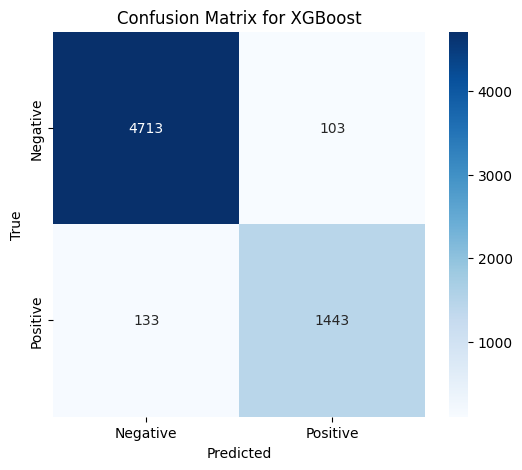

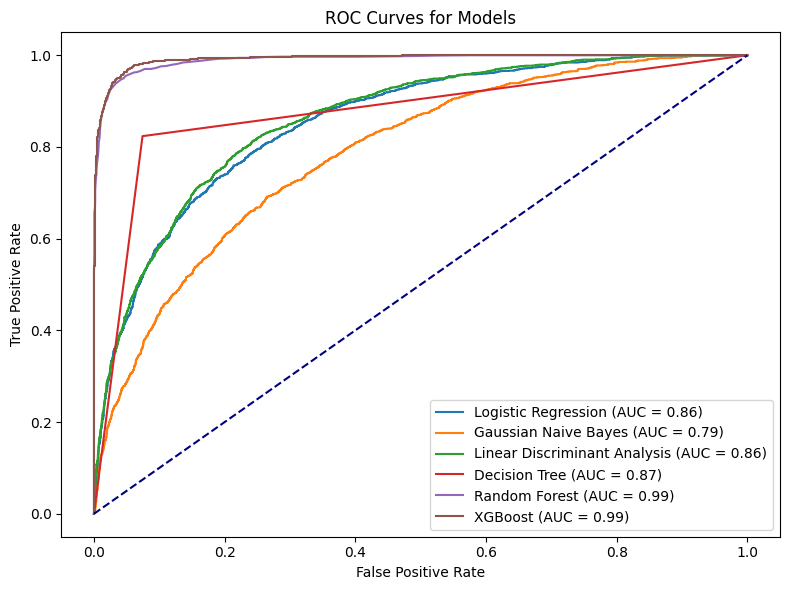

In [ ]:
# Split data into train, validation, and test sets
X_combined = np.concatenate([audio_features_array, imu_features_array], axis=1)
y = labels_array

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Split training set further into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

# Function to train and evaluate a model
def train_and_evaluate_model(X_train, X_val, y_train, y_val, model_name="Model", model=None):
    """Trains, evaluates a model, and prints detailed performance metrics."""
    model.fit(X_train, y_train)

    # Predictions and evaluation on validation data
    y_pred_val = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_pred_val)
    val_report = classification_report(y_val, y_pred_val)
    val_cm = confusion_matrix(y_val, y_pred_val)

    # Print results for the validation set
    print(f"🔹 {model_name} Validation Accuracy: {val_accuracy:.4f}")
    print(f"Classification Report:\n{val_report}")
    print(f"Confusion Matrix:\n{val_cm}")

    # Return the trained model and its evaluation
    return model, val_accuracy, val_report, val_cm

# Function to evaluate the model on test data
def evaluate_model_on_test(model, X_test, y_test, model_name="Model"):
    """Evaluates the trained model on the test set."""
    y_pred_test = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_report = classification_report(y_test, y_pred_test)
    test_cm = confusion_matrix(y_test, y_pred_test)

    # Print results for the test set
    print(f"✅ {model_name} Test Accuracy: {test_accuracy:.4f}")
    print(f"Classification Report:\n{test_report}")
    print(f"Confusion Matrix:\n{test_cm}")

    # Return the evaluation results
    return test_accuracy, test_report, test_cm

# Store results in a dictionary
model_results = {}

# List of models for training and evaluation (already defined in the first cell)
models_names = list(models.keys())

# Iterate over each model and evaluate its performance
for model_name in models_names:
    print(f"\n🔹 Training {model_name}...")

    model = models[model_name]

    # Train and evaluate model
    trained_model, val_accuracy, val_report, val_cm = train_and_evaluate_model(X_train, X_val, y_train, y_val, model_name, model)

    # Evaluate on the test set
    test_accuracy, test_report, test_cm = evaluate_model_on_test(trained_model, X_test, y_test, model_name)

    # Store results
    model_results[model_name] = {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy,
        'val_cm': val_cm,
        'test_cm': test_cm,
        'val_report': val_report,
        'test_report': test_report,
        'y_true': y_test,
        'y_pred_proba': trained_model.predict_proba(X_test)[:, 1]
    }

# Function to plot results (accuracy and confusion matrix)
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(model_results, models_names):
    """Visualizes the model comparison in terms of accuracy and confusion matrix."""

    # Prepare data for the bar plot (accuracy comparison)
    val_accuracies = [result['val_accuracy'] for result in model_results.values()]
    test_accuracies = [result['test_accuracy'] for result in model_results.values()]

    # Create a bar plot to compare the models
    x = np.arange(len(model_results))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.bar(x - width/2, val_accuracies, width, label='Validation Accuracy')
    ax.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('Model Comparison (Validation and Test Accuracy)')
    ax.set_xticks(x)
    ax.set_xticklabels(models_names, rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot confusion matrices for each model
    for model_name in models_names:
        cm = model_results[model_name]['test_cm']
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    # Optional: Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for model_name in models_names:
        y_true = model_results[model_name]['y_true']
        y_pred_proba = model_results[model_name]['y_pred_proba']
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Models')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Plot comparison results
plot_results(model_results, models_names)

In [ ]:
# Count the number of coughs for each sample
cough_counts = np.sum(labels_array == 1)

print(f"Total number of coughs in the dataset: {cough_counts}")


Total number of coughs in the dataset: 7990


In [ ]:
# Check the total_coughs value after loading each subject
for subject_dir in subject_dirs:
    npz_file_path = os.path.join(dataset_folder, subject_dir, 'processed_subject_' + subject_dir + '.npz')
    data = np.load(npz_file_path)
    total_coughs = data.get('total_coughs', 0)  # Make sure to get total_coughs key if available
    print(f"Subject {subject_dir} has {total_coughs} total coughs.")

Subject 14287 has 255 total coughs.
Subject 14342 has 215 total coughs.
Subject 14547 has 301 total coughs.
Subject 20794 has 167 total coughs.
Subject 38936 has 338 total coughs.
Subject 47779 has 320 total coughs.
Subject 49661 has 251 total coughs.
Subject 55502 has 417 total coughs.
Subject 76918 has 335 total coughs.
Subject 84479 has 280 total coughs.
Subject 86463 has 267 total coughs.
Subject 87369 has 262 total coughs.
Subject 87447 has 291 total coughs.
Subject 97706 has 296 total coughs.
